In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('./data/encoded_data.csv')
seed = 42  # for reproducibility

In [2]:
df.shape

(16731, 132)

In [3]:
df.dropna(inplace=True)
df.shape

(14325, 132)

In [4]:
response = 'Price'

X = df.drop([response], axis=1)
y = df[response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

# store shapes in dictionary to prepare for printing
shapes = {
	'X': {
		'train': str(X_train.shape),
		'val':   str(X_val.shape),
		'test':  str(X_test.shape),
	},
	'y': {
		'train': str(y_train.shape),
		'val':   str(y_val.shape),
		'test':  str(y_test.shape),
	}
}
# scale the data
"""scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
"""
# find maximum widths of
# [0] split names
# [1] X shapes
# [2] y shapes
maxes = list(map(
	lambda shape_list: len(max(shape_list, key=len)),
	[shapes['X'].keys(), shapes['X'].values(), shapes['y'].values()]
))

# print with found widths
for split, shape in shapes['X'].items():
	print(
		f'X_{split:<{maxes[0]}}: {shape:<{maxes[1]}}'
	)
for split, shape in shapes['y'].items():
	print(
		f'y_{split:<{maxes[0]}}: {shape:<{maxes[1]}}'
	)

X_train: (10743, 131)
X_val  : (1791, 131) 
X_test : (1791, 131) 
y_train: (10743,)    
y_val  : (1791,)     
y_test : (1791,)     


In [5]:
alphas = list(sorted(set(
	[ratio / 10 for ratio in range(1, 20)] + [numb for numb in range(2, 50,5)]
)))
l1_ratios = np.arange(0, 1, 0.1).tolist()

In [6]:
print(f'alphas: {alphas}')

alphas: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 7, 12, 17, 22, 27, 32, 37, 42, 47]


In [7]:
def parameter_search(
	method: str, 
	estimator = ElasticNet(), 
	params = {'alpha': alphas, 'l1_ratio': l1_ratios},
	scoring = 'r2',
	cv: int = 3
):
	match method:
		case 'random':
			searcher = RandomizedSearchCV(
				estimator = estimator,
				param_distributions = params,
				scoring = scoring,
				cv = cv,
				random_state = seed
			)
		case 'grid':
			searcher = GridSearchCV(
				estimator = estimator,
				param_grid = params,
				scoring = scoring,
				cv = cv,
			)

	#searcher.fit(X_train, y_train)
	searcher.fit(X_train, y_train)

	best_alpha = searcher.best_params_['alpha']
	if params.get("l1_ratio") is not None:
		best_l1 = searcher.best_params_['l1_ratio']
		print(
			f"The optimal value of alpha is {best_alpha} and "
			f"for l1_ratio {best_l1} based on {method} search."
		)
		return best_alpha, best_l1
	else:
		print(
			f"The optimal value of alpha is {best_alpha} and "
		)
		return best_alpha

In [8]:
best_alpha_random, best_l1_random = parameter_search('random')

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e+12, tolerance: 5.475e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+12, tolerance: 5.398e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

The optimal value of alpha is 0.1 and for l1_ratio 0.9 based on random search.


In [9]:
best_alpha_grid, best_l1_grid = parameter_search('grid')

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+12, tolerance: 5.475e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+12, tolerance: 5.398e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

The optimal value of alpha is 0.1 and for l1_ratio 0.9 based on grid search.


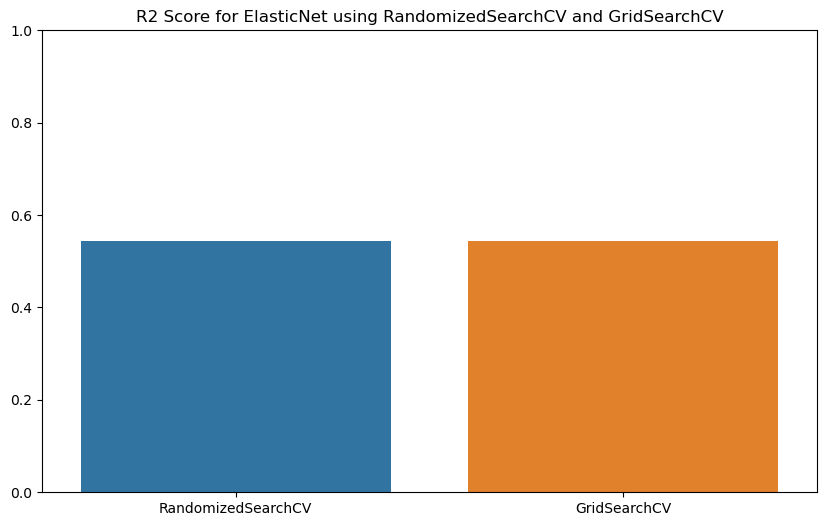

In [10]:
alphasToTest = [best_alpha_random, best_alpha_grid]
l1_ratiosToTest = [best_l1_random, best_l1_grid]
scores = []
for alpha, ratio in zip(alphasToTest, l1_ratiosToTest):
	reg_mod = ElasticNet(alpha=alpha, l1_ratio=ratio)
	reg_mod.fit(X_train, y_train)
	y_pred = reg_mod.predict(X_val)
	scores.append(r2_score(y_val, y_pred))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x = ["RandomizedSearchCV","GridSearchCV"] , y=scores)
ax.set(ylim=(0, 1))
plt.title('R2 Score for ElasticNet using RandomizedSearchCV and GridSearchCV')
plt.show()

As the plot above shows, the GridSearch significantly outperformed the RandomizedSearch, therefore despite the higher computational costs, the grid search method is implemented in the followings to fine-tune the Lasso and Ridge regression models.

In [12]:
best_alpha_random_ridge = parameter_search('grid', Ridge(), params={'alpha': alphas})

The optimal value of alpha is 0.9 and 


In [13]:
best_alpha_random_lasso = parameter_search('grid', Lasso(), params={'alpha': alphas})

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e+11, tolerance: 5.475e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e+11, tolerance: 5.398e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+11, toleranc

The optimal value of alpha is 17 and 


In [19]:
alphasToTest = [best_alpha_random, best_alpha_grid, best_alpha_random_ridge, best_alpha_random_lasso]
l1_ratiosToTest = [best_l1_random, best_l1_grid, np.NaN, np.NaN]
Results = {} #['ElasticNet Randomized', 'ElasticNet Grid', 'Ridge Randomized', 'Lasso Randomized']
# ElasticNet Randomized
reg_mod = ElasticNet(alpha=alphasToTest[0], l1_ratio=l1_ratiosToTest[0])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['ElasticNet using Randomized search'] = r2
# ElasticNet Grid
reg_mod = ElasticNet(alpha=alphasToTest[1], l1_ratio=l1_ratiosToTest[1])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['ElasticNet using Grid search'] = r2
# Ridge Randomized
reg_mod = Ridge(alpha=alphasToTest[2])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['Ridge Regression'] = r2
# Laso Randomized
reg_mod = Lasso(alpha=alphasToTest[3])
reg_mod.fit(X_train, y_train)
y_pred = reg_mod.predict(X_val)
r2 = r2_score(y_val, y_pred)
Results['Lasso Regression'] = r2

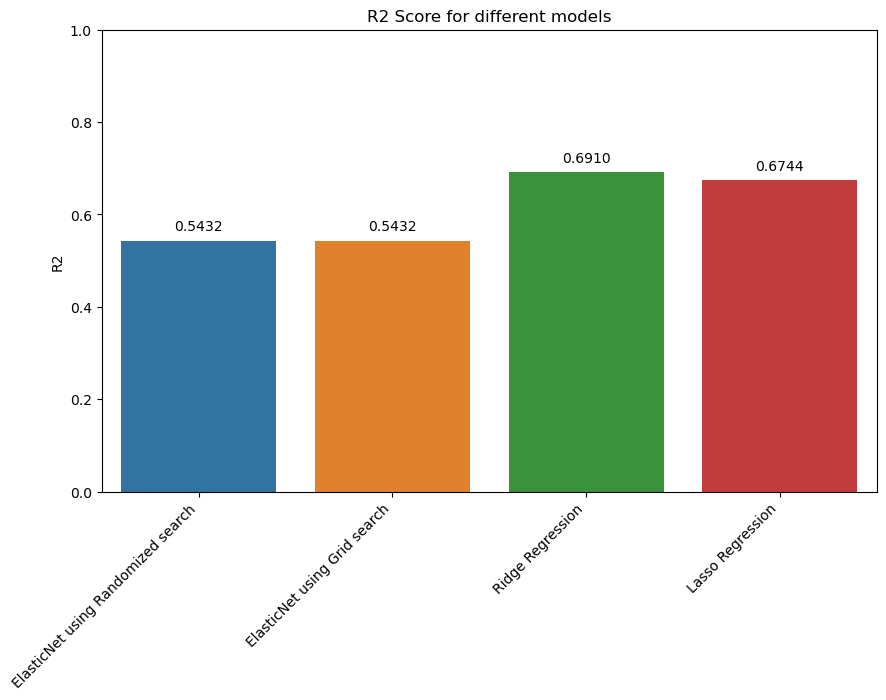

In [20]:
results_df = pd.DataFrame.from_dict(Results, orient='index', columns=['R2'])
results_df["Parameter alpha"] = alphasToTest
results_df["Parameter l1_ratio"] = l1_ratiosToTest
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = results_df.index , y=results_df.R2)
ax.set(ylim=(0, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('R2 Score for different models')
#plt.savefig('diagrams/model_check.png')
plt.show()
#results_df.plot(kind='bar', rot=45, legend=False, title='R2 for different models')

In [21]:
results_df.sort_values(by='R2', ascending=False, inplace=True)
results_df.to_csv('./data/model_results.csv')
results_df

,R2,Parameter alpha,Parameter l1_ratio
Ridge Regression,0.690956,0.9,NaN
Lasso Regression,0.674431,17.0,NaN
ElasticNet using Randomized search,0.543226,0.1,0.9
ElasticNet using Grid search,0.543226,0.1,0.9
